/home/dronelab/delaunay_rasterization
Vertex Torch Grad: [[ 7.1600792e-03 -7.4509638e-03 -9.3718907e-03]
 [-1.1085331e-03 -7.7645672e-03  2.2603339e-03]
 [-6.8819318e-03 -4.9076156e-05  8.5131256e-03]
 [-5.9600374e-05 -3.9759622e-04 -1.8482786e-03]
 [ 3.2466091e-03 -2.5577291e-03  9.4579831e-03]
 [ 1.7904920e-04 -5.8015768e-04  5.9687387e-04]
 [ 2.0385210e-03  5.4601808e-03  1.2771254e-03]
 [-1.3671340e-03  1.0606113e-03  1.6527256e-03]
 [-6.0727671e-03 -8.5469913e-03 -1.9825926e-02]]
Vertex Jax Grad: [[ 0.          0.          0.        ]
 [-0.00023838 -0.00103893  0.0001654 ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.00028605  0.00124672 -0.00019849]
 [ 0.          0.          0.        ]]
RGBS Torch Grad: [[ 5.3805782e-04  5.3805782e-04  5.3805782e-04  1.0084760e-03]
 [ 9.9392217e-03  9.9392217e-03  9.9392217e-03  5.8752676e-03

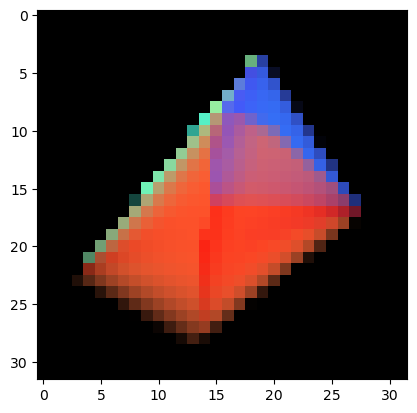

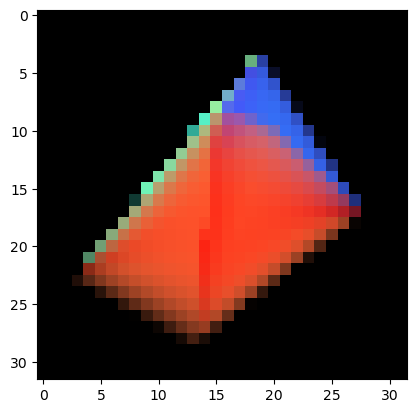

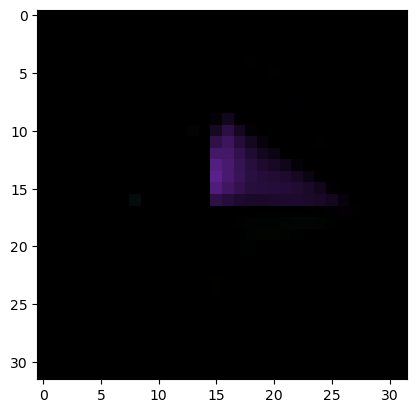

In [2]:
import os
VERSION = 9
if VERSION is not None:
    os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
    os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.append(str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))

from utils.compare_quad import test_tetrahedra_rendering
import torch
import matplotlib.pyplot as plt
import numpy as np
from tests.multi_tet_test import compute_delaunay, generate_color_palette

vertices = torch.tensor([[ 82.0274, -18.4694, -24.9800],
        [ 16.4444, -85.1786,  15.7477],
        [-60.0877, -35.8837,  35.0281],
        [ 15.8717,  43.5945, -47.4486],
        [ 34.9285, -17.3869,  68.8306],
        [  4.3706,  49.3245, -10.7796],
        [ 16.6389, -73.1920,  -6.8073],
        [  3.1553,  83.7309,  30.8407],
        [-71.2365, -19.4960, -29.1383]], device='cuda:0')
viewmat = torch.tensor([[ 4.8467e-01,  6.8136e-09,  8.7470e-01, -5.3092e+00],
        [-8.3698e-01,  2.9050e-01,  4.6377e-01,  4.6587e+00],
        [ 2.5410e-01,  9.5688e-01, -1.4080e-01,  1.0075e+02],
        [ 3.8037e-10,  1.8915e-10, -2.4838e-11,  1.0000e+00]], device='cuda:0')
vertices = torch.tensor([[ 8.2027, -1.8469, -2.4980],
        [ 1.6444, -8.5179,  1.5748],
        [-6.0088, -3.5884,  3.5028],
        [ 1.5872,  4.3595, -4.7449],
        [ 3.4928, -1.7387,  6.8831],
        [ 0.4371,  4.9325, -1.0780],
        [ 1.6639, -7.3192, -0.6807],
        [ 0.3155,  8.3731,  3.0841],
        [-7.1237, -1.9496, -2.9138]], device='cuda:0')
viewmat = torch.tensor([[ 5.7009e-01, -8.5568e-09,  8.2158e-01, -5.5242e-01],
        [-7.9130e-01,  2.6898e-01,  5.4908e-01,  3.9739e-01],
        [ 2.2099e-01,  9.6315e-01, -1.5334e-01,  1.9988e+01],
        [ 3.7314e-09,  3.0741e-09,  3.2300e-09,  1.0000e+00]], device='cuda:0')

indices = compute_delaunay(vertices)
colors = generate_color_palette(len(indices))

# Run test
results = test_tetrahedra_rendering(
    vertices.cuda(), indices, colors, viewmat,
    height=32, width=32, tile_size=4)
    # height=8, width=8)


print(f"Vertex Torch Grad: {results['torch_vertex_grad']}")
print(f"Vertex Jax Grad: {results['jax_vertex_grad']}")
print(f"RGBS Torch Grad: {results['torch_rgbs_grad']}")
print(f"RGBS Jax Grad: {results['jax_rgbs_grad']}")
print(f"Max value torch: {results['torch_image'].max()}")
print(f"Max value jax: {results['jax_image'].max()}")
print(f"Mean Error: {results['mean_error']}")
print(f"Max Error: {results['max_error']}")
plt.imshow(results['torch_image'])
plt.show()
plt.imshow(results['jax_image'][..., :3])
plt.show()
plt.imshow(np.abs(results['jax_image'][..., :3] - results['torch_image']))
plt.show()
